# Projeto Final EEL7514 - Neural Style Transfer
Alunos: 
         __Bruno Griep Fernandes__ e 
         __Roberto Phillipi Martins__

__Neural Style Transfer__ é o processo em que retira-se o estilo de uma imagem de referência e aplica-se esse estilo em uma imagem alvo. Um exemplo prático disso seria em usar uma foto de uma casa como alvo e uma obra de arte como referência. Dessa forma ao transferir o estilo da obra de arte a imagem gerada irá parecer que a casa foi criada pelo artista da obra de arte. Vale lembrar que é gerada uma nova imagem, ou seja, são duas duas entradas e uma saída, onde as entradas não são modificadas.

__Estilo__ para definirmos o estilo algumas features são importantes sedo elas: 
        - A coloração;
        - A textura;  
        - O padrão.
__Content__ é definido como a estrutura total e as compoentes de alto nível da imagem. O objetivo principal é manter o conteúdo original da imagem de alvo, isso enquanto o estilo é transferindo.

__Algorítmo__ funciona basicamente na minimização de uma função custo, que envolve as imagens de conteúdo (C), estilo (S) e gerada (G).



\begin{align*}
    J(C,S,G) &= \alpha Jc(C,G) + \beta Js(S,G)\\
    Jc(C,G)^{[L]} &=  \frac{1}{2}||a^{[L][G]}-a^{[L][G]}||^2\\
    Js(S,G)^{[L]} &= \frac{1}{2} ||G^{[L][S]}-G^{[L][G]}||^2\\
    G^{[L][I]} &=\left(\sum_{k=0}^{k=ch}\sum_{k'=0}^{k'=ch} \right)
\sum_{i=0}^{i=w}\sum_{j=0}^{j=h}||a^{[L][i][j][k]}-a^{[L][i][j][k']}||^2
\end{align*}

Onde Jc(C,G) representa a distância euclidiana entre as ativações da imagem C e imagem G numa camada L. Como queremos minimizar o custo, isso significa que queremos que as representações de C e G na camada L sejam similares.

No caso de Js(S,G), nós definimos o "estilo" de uma imagem como a correlação entre os canais de uma camada de ativação da rede convolucional. Este valor é definido como G (Gram Matrix),e é a matriz de correlação entre os diversos canais de uma camada da rede convolucional. 

O objetivo é que o estilo da imagem G seja similar ao estilo da imagem S, e portanto Js(S,G) é definido como a distância euclidiana entre os estilos das duas imagens.

Definido o custo, o objetivo do algorítimo é minimizar a função J(C,S,G), e pode ser resolvido com algorítimos como Gradient Descent

__Loss__ no nosso contexto de processamento de imagens podemos definir a perda a partir da seguinte forma:
$$loss = distance(style(Image_{reference}) - style(Image_{generated})) +
       distance(content(Image_{original}) - content(Image_{generated}))$$
       
Onde, 

- $distance$ é a distância euclidiana.
- $style$ é a função que calcula a presença do estilo na imagem de referência na gerada.
- $content$ é a função que calcula a representação do conteúdo da imagem original na gerada.
(essa parte aqui melhorar, ficou estranho)


# Referências:
 
- Image Super-Resolution Using CNN - https://arxiv.org/abs/1501.00092 
- A Neural Algorithm of Artistic Style - https://arxiv.org/abs/1508.06576
- Improving the Neural Algorithm of Artistic Style - https://arxiv.org/abs/1605.04603
- Preserving Color in Neural Artistic Style - https://arxiv.org/abs/1606.05897
- very Deep Convolutional Networks for Large-Scale Image Recognition - https://arxiv.org/abs/1409.1556

## Visualizando as imagens a ser utilizidas

In [24]:
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input,decode_predictions

Using TensorFlow backend.


In [3]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [4]:
datapath = 'data/'
content = Image.open(datapath + 'content/golden_gate.jpg')
style = Image.open(datapath + 'style/wave_kanagawa.jpg')

print('Content Shape:',np.shape(content),'\nStyle Shape:', np.shape(style))

Content Shape: (734, 979, 3) 
Style Shape: (707, 1131, 3)


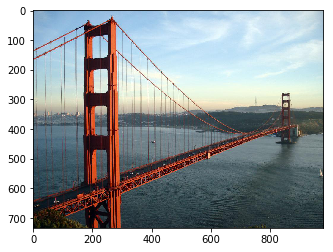

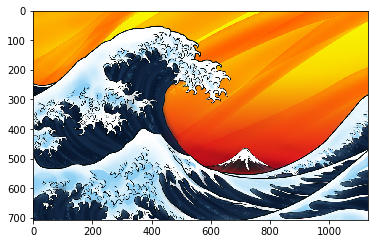

In [5]:
plt.imshow(content)
plt.figure()
plt.imshow(style)

## Pré-processamento das Imagens

Aqui alguns passos serão feitos para que o processamento usando a rede VGG serja mais curto em quesitos de tempo.
    - Modifica-se as dimensões das duas imagens para ambas terem o mesmo tamanho;
    - Substrai o valor médio de cores (RGB);
    - Inverte-se a ordem multidimencional do array de cores, ou seja, ao invés de usar o padrão RGB usa-se o BGR.

In [6]:
height = 512
width = 512

content = content.resize((height,width))
style = style.resize((height,width))

content_array = np.asarray(content,dtype='float32')
content_array = np.expand_dims(content_array,axis=0)

style_array = np.asarray(style,dtype='float32')
style_array = np.expand_dims(style_array,axis=0)

print('Content Shape:',content_array.shape,'\nStyle Shape:', style_array.shape)

Content Shape: (1, 512, 512, 3) 
Style Shape: (1, 512, 512, 3)


In [7]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]

print('Content Shape:',content_array.shape,'\nStyle Shape:  ', style_array.shape)

Content Shape: (1, 512, 512, 3) 
Style Shape:   (1, 512, 512, 3)


Feitas as modificações parte-se para a definição das variáveis do backend do keras.

In [8]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Concatena-se as imagens para um único tensor para ser utilizado na rede VGG19

In [9]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

# Carregando a Rede pré-treinada

Usaremos uma rede pré treinada para classificação de imagens, o motivo para isso seria a minimização do tempo de treinamento, pois a rede VGG16 ou VGG19 são CNNs pré treinadas utilizando ao banco de dados do Google, o ImageNet.
Dessa forma a extração de features fica mais simples e com um ótimo resultado.

Alguns dos artigos de referência [colocar aqui depois] apresentam abordagem de usar um layer específico, um deles usa
o layer 19, outro a 16. Porém o critério de escolha para tal baseia-se em escolhas de gosto, ou seja, algo arbitrário e não objetivo. 
Como não estamos interessados em classificar as imagens utilizadas, não há necessidade de utilizar uma rede fully connected layers com classifição softmax. Precisa-se apenas da região marcada na figura abaixo (retirada de uma das referências).
<img src="nbimages/vgg-architecture.png">

In [10]:
model = VGG19(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [11]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <t

In [12]:
#style_weights_default = [0.2, 2*0.2, 3*0.2, 4*0.2, 5*0.2]

# todos pesos podem ser alterados

content_weight = 0.025  #
style_weight = 5.0
total_variation_weight = 1.0

In [13]:
loss = backend.variable(0.)

# AVISO ROBERTO:

Aqui pra frente eu só copiei pra testar, mas podemos fazer modificações.
No geral o que eu fizer by my own escreverei uns textos antes explicando tudo, pra já ir organizando.

In [14]:
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)


In [15]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

In [16]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [17]:
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [18]:
loss += total_variation_weight * total_variation_loss(combination_image)

In [19]:
grads = backend.gradients(loss, combination_image)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = backend.function([combination_image], outputs)

In [20]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [21]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [22]:
evaluator=Evaluator()

In [25]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 331468440000.0
Iteration 0 completed in 98s
Start of iteration 1
Current loss value: 139296500000.0
Iteration 1 completed in 88s
Start of iteration 2
Current loss value: 103768910000.0
Iteration 2 completed in 88s
Start of iteration 3
Current loss value: 86987730000.0
Iteration 3 completed in 90s
Start of iteration 4
Current loss value: 75599170000.0
Iteration 4 completed in 88s
Start of iteration 5
Current loss value: 67754150000.0
Iteration 5 completed in 88s
Start of iteration 6
Current loss value: 61948813000.0
Iteration 6 completed in 89s
Start of iteration 7
Current loss value: 57837093000.0
Iteration 7 completed in 88s
Start of iteration 8
Current loss value: 54963570000.0
Iteration 8 completed in 88s
Start of iteration 9
Current loss value: 52491706000.0
Iteration 9 completed in 88s


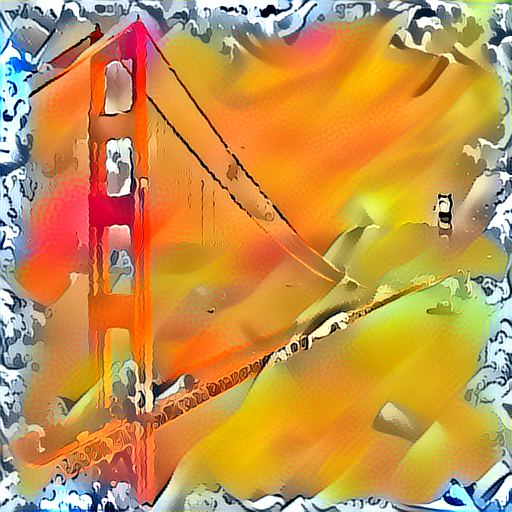

In [26]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)